Modeling the effect of electrolyte properties on discharge capacity and degradation (cycle life)

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

Set up model with SEI growth

In [44]:
parameter_values = pybamm.ParameterValues("Chen2020")
# input parameter sigma_e is in mS/cm (10 mS/cm = 1 S/m)
parameter_values["Electrolyte conductivity [S.m-1]"] = pybamm.InputParameter("sigma_e") / 10
parameter_values["Outer SEI solvent diffusivity [m2.s-1]"] = 2e-21

model = pybamm.lithium_ion.DFN({
    "SEI": "solvent-diffusion limited"
})

sigmas = np.arange(5,13)

### Capacity during 4C discharge

In [31]:
discharge = pybamm.Experiment([
    "Discharge at 2C until 2.5V",
])

sim = pybamm.Simulation(model, experiment=discharge, parameter_values=parameter_values)
sols = []
for sigma_e in sigmas:
    sol = sim.solve(inputs={"sigma_e": sigma_e}, initial_soc=1)
    sols.append(sol)

Plot every 3rd solution

In [32]:
pybamm.dynamic_plot(sols[::3])

interactive(children=(FloatSlider(value=0.0, description='t', max=1727.0179978189867, step=17.270179978189866)…

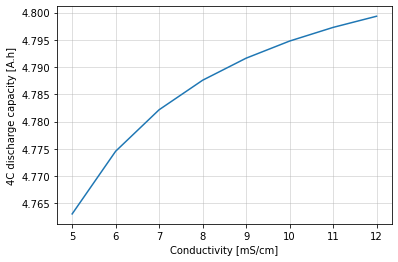

In [33]:
caps = [sol["Discharge capacity [A.h]"].data[-1] for sol in sols]
fig, ax = plt.subplots()
ax.plot(sigmas, caps)
ax.set_xlabel("Conductivity [mS/cm]")
ax.set_ylabel("4C discharge capacity [A.h]")
ax.grid(alpha=0.5)

### Degradation during CCCV charge

In [45]:
charge = pybamm.Experiment([
    "Charge at 2C until 4.2V",
    "Hold at 4.2V until C/50",
])

sim = pybamm.Simulation(model, experiment=charge, parameter_values=parameter_values)
sols = []
for sigma_e in sigmas:
    sol = sim.solve(inputs={"sigma_e": sigma_e}, initial_soc=0)
    sols.append(sol)

The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Plot every 3rd solution

In [46]:
pybamm.dynamic_plot(sols[::3], 
                    ["Terminal voltage [V]", 
                     "Loss of lithium inventory [%]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=1.8126148382441056, step=0.01812614838244105…

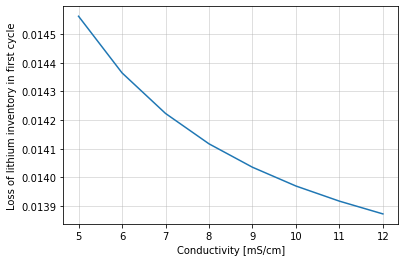

In [47]:
LLIs = [sol["Loss of lithium inventory [%]"].data[-1] for sol in sols]
fig, ax = plt.subplots()
ax.plot(sigmas, LLIs)
ax.set_xlabel("Conductivity [mS/cm]")
ax.set_ylabel("Loss of lithium inventory in first cycle")
ax.grid(alpha=0.5)

### Calculate capacity and extrapolate cycle life

In [48]:
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)

param = pybamm.LithiumIonParameters()

Vmin = parameter_values["Lower voltage cut-off [V]"]
Vmax = parameter_values["Upper voltage cut-off [V]"]
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li = parameter_values.evaluate(param.n_Li_particles_init)

esoh_sol = esoh_sim.solve([0], inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li})
C_init = esoh_sol["C"].data[0]

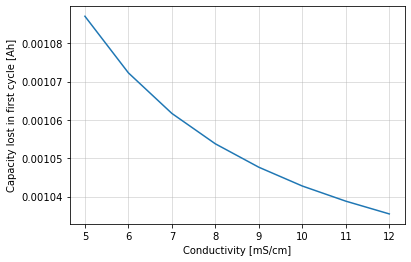

In [49]:
C_loss = [C_init - sol.summary_variables["C"][-1] for sol in sols]
fig, ax = plt.subplots()
ax.plot(sigmas, C_loss)
ax.set_xlabel("Conductivity [mS/cm]")
ax.set_ylabel("Capacity lost in first cycle [Ah]")
ax.grid(alpha=0.5)

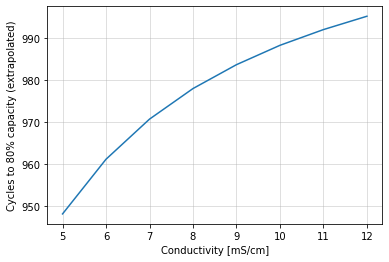

In [50]:
# End of life when 20% of initial capacity is lost
cycle_life = 0.2*C_init / C_loss
fig, ax = plt.subplots()
ax.plot(sigmas, cycle_life)
ax.set_xlabel("Conductivity [mS/cm]")
ax.set_ylabel("Cycles to 80% capacity (extrapolated)")
ax.grid(alpha=0.5)